In [1]:
import pandas as pd
from sqlalchemy import create_engine, text

In [2]:
import sys

# os.chdir('C:/Users/user/Documents/hs/pipeline-main/pipeline-main/')

sys.path.append('../py')

import data_processing as proc
import utils
import performance as perf


2025-06-04 13:30:25.667197: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 13:30:25.723859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import cx_Oracle
import os
os.putenv(' NLS_LANG', '.UTF8')

In [4]:
dsn = cx_Oracle.makedsn('192.168.1.5', '1521', service_name = 'ORA11')
con = cx_Oracle.connect('dbam', 'dbamkass', dsn = dsn, encoding="UTF-8")
cur = con.cursor()

In [5]:
sql_k200 = " select 일자, 종목코드2 종목코드, 종목명_국문 종목명, 당일가격, 지수내비중, 상장주식수, 유동비율, \
            지수주식수, 지수시가총액 \
             from KASS1.TH068 \
             where 익일적용여부 ='NXT' \
             and ISIN = 'KRD020020016' \
             order by 지수내비중 desc "

cur.execute(sql_k200)
k200_df = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])

In [6]:
k200_df['일자']=pd.to_datetime(k200_df['일자'], format ='%Y%m%d')
k200_df.set_index(['일자', '종목코드'], inplace=True)
k200_df.index.names=['Dates', 'Symbol']
k200_df.columns=['name', 'close', 'idx_weight', 'num_shares', 'float_rate', 'idx_num_shares', 'idx_cap']


In [7]:
k200_df=k200_df.sort_index(level='Dates')

In [8]:
host = '192.168.1.27'
port = '3306'
db_name = 'quantdb_maria'
username = 'quantdb'
password = 'QuantDb2023!'

engine = create_engine("mysql+pymysql://" + username + ":" + password + "@" + host + ":" + port + "/" + db_name)
conn=engine.connect()

In [9]:
period1='2014-09-01'
period2='2025-05-30'

In [10]:
query_COM=f"select * from fn_COM where Dates>='{period1}' and Dates<='{period2}'"
data_COM=pd.read_sql(query_COM, conn)

In [11]:
data_COM.set_index(['Dates','Symbol'], inplace=True)

In [12]:
data_COM_nodup=data_COM.loc[~data_COM.index.duplicated(keep='last')].copy()

In [13]:
query_SSC=f"select * from fn_SSC where Dates>='{period1}' and Dates<='{period2}'"
data_SSC=pd.read_sql(query_SSC, conn)

In [14]:
data_SSC.set_index(['Dates','Symbol'], inplace=True)

In [15]:
data_SSC_nodup=data_SSC.loc[~data_SSC.index.duplicated(keep='last')].copy()

In [16]:
data_SSC.columns

Index(['Name', 'MNGT', 'ClosePrc', 'OpenPrc', 'HighPrc', 'LowPrc', 'AdjPrc',
       'AdjPrc2', 'AdjPrc_High_20D', 'AdjPrc_Low_20D', 'AdjPrc_High_60D',
       'AdjPrc_Low_60D', 'AdjPrc_High_120D', 'AdjPrc_Low_120D',
       'AdjPrc_High_52W', 'AdjPrc_Low_52W', 'ListedShares', 'ForeignStake',
       'TradeStop', 'MktCap_Comm_Pref', 'MktCapCom', 'MktCap', 'Volume',
       'Volume_Avg_20D', 'Volume_Avg_60D', 'Volume_Avg_120D', 'Volume_Avg_52W',
       'Amt_Avg_20D', 'Amt_Avg_60D', 'Amt_Avg_120D', 'Amt_Avg_52W', 'Vol_20D',
       'Vol_120D'],
      dtype='object')

In [17]:
data_COM.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [18]:
query_idx=f"select * from krx_idx"
krx_idx=pd.read_sql(query_idx, conn)

In [19]:
krx_idx.set_index('Dates', inplace=True)


<Axes: xlabel='Dates'>

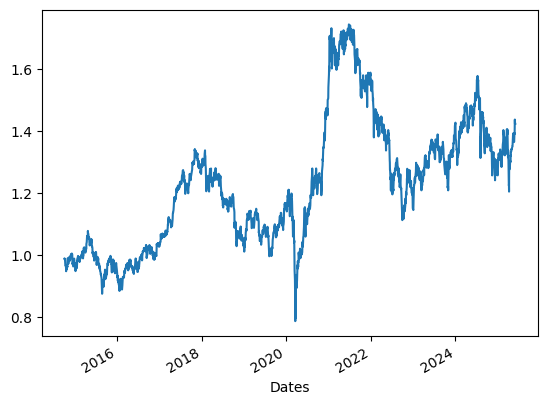

In [20]:
(1+krx_idx['코스피 200'].pct_change().loc['2014-10-02':]).cumprod().plot()

# backtesting

In [21]:
adjprc=data_SSC_nodup['AdjPrc'].unstack()
adjprc=adjprc.astype(float)

In [93]:
data_path='../data/output/prob_out/'
file_name='prob_res_2014-01-29_2025-05-30_ver0.1.csv'
# hyungshin.lee/data/output/prob_out/prob_res_2013-01-25_2023-08-31.csv
raw_prob=pd.read_csv(data_path+file_name, index_col=0)

# mlq_w=pd.read_excel(data_path + 'monthly_port.xlsx', index_col=0)

In [94]:
raw_prob.index

Index(['2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-04-04',
       '2025-04-11', '2025-04-18', '2025-04-25', '2025-05-02', '2025-05-09',
       '2025-05-16', '2025-05-23', '2025-05-30'],
      dtype='object', name='Dates')

In [95]:
raw_prob

,A000080,A000100,A000120,A000150,A000210,A000240,A000270,A000660,A000720,A000810,...,A373220,A375500,A377300,A383220,A402340,A450080,A454910,A456040,A457190,A003240
Dates,,,,,,,,,,,,,,,,,,,,,
2025-03-07,1.390562e-08,8.187970e-09,1.616169e-08,5.831834e-09,1.573899e-08,1.606068e-08,8.748594e-09,4.883370e-09,9.840099e-09,1.109004e-08,...,1.504907e-08,1.308110e-08,1.087525e-08,1.465575e-08,1.237553e-08,6.134059e-10,1.212978e-08,1.666267e-08,2.827304e-08,NaN
2025-03-14,1.376407e-08,9.526644e-09,1.327301e-08,5.945156e-09,1.466705e-08,1.582713e-08,9.713501e-09,6.018162e-09,9.628081e-09,1.009266e-08,...,1.301691e-08,1.095734e-08,1.110475e-08,1.310815e-08,1.214150e-08,5.559065e-10,1.174220e-08,1.600750e-08,2.119391e-08,1.199320e-08
2025-03-21,1.361093e-08,7.296004e-09,1.258577e-08,4.274032e-09,1.423022e-08,1.552036e-08,9.223946e-09,8.407682e-09,9.602900e-09,1.092598e-08,...,1.307401e-08,1.097206e-08,0.000000e+00,1.314578e-08,1.184416e-08,5.001120e-10,1.052078e-08,1.405682e-08,1.556352e-08,1.122200e-08
2025-03-28,1.365209e-08,7.673878e-09,1.338878e-08,5.405532e-09,1.423155e-08,1.636767e-08,1.015203e-08,6.980045e-09,9.460803e-09,1.243535e-08,...,1.383762e-08,1.124218e-08,0.000000e+00,1.318093e-08,1.321950e-08,5.348804e-10,1.166855e-08,1.469965e-08,1.562231e-08,9.286454e-09
2025-04-04,1.254668e-08,9.083315e-09,1.341342e-08,6.939676e-09,1.435384e-08,1.426784e-08,1.238172e-08,7.373662e-09,1.052787e-08,9.913854e-09,...,1.085038e-08,1.266725e-08,1.026700e-08,1.485095e-08,1.257929e-08,1.074943e-08,1.008933e-08,1.375387e-08,1.186700e-08,1.349760e-08
2025-04-11,1.169914e-08,9.658005e-09,1.270432e-08,9.621564e-09,1.367975e-08,1.364733e-08,9.640154e-09,4.938550e-09,1.110176e-08,1.008166e-08,...,1.005105e-08,1.272192e-08,1.309070e-08,1.410239e-08,1.286459e-08,1.127558e-08,1.013143e-08,1.434569e-08,1.117800e-08,1.341981e-08
2025-04-18,1.161920e-08,1.002247e-08,1.292505e-08,9.116380e-09,1.340787e-08,1.393767e-08,1.044562e-08,3.694834e-09,1.036475e-08,1.056930e-08,...,9.964317e-09,1.202699e-08,1.267933e-08,1.346165e-08,1.287404e-08,1.056859e-08,9.506205e-09,1.365571e-08,1.131433e-08,1.317022e-08
2025-04-25,1.111551e-08,9.550203e-09,1.245389e-08,9.740904e-09,1.349852e-08,1.360099e-08,9.957934e-09,3.717567e-09,9.975328e-09,1.042604e-08,...,9.928651e-09,1.181605e-08,1.168503e-08,1.313445e-08,1.266657e-08,1.004992e-08,9.939375e-09,1.459786e-08,1.043041e-08,1.306352e-08
2025-05-02,1.139183e-08,6.075332e-09,1.158572e-08,7.742566e-09,1.339542e-08,1.554379e-08,1.030272e-08,3.732815e-09,5.570435e-09,1.210535e-08,...,7.251539e-09,1.023650e-08,1.237346e-08,1.312200e-08,1.365615e-08,2.863239e-09,8.112235e-09,1.199803e-08,8.998337e-09,8.876472e-09


In [96]:
# raw_prob.reset_index(inplace=True)
# raw_prob.set_index(['Dates', 'Symbol'], inplace=True)
# raw_prob=raw_prob.unstack()
# raw_prob.columns=raw_prob.columns.get_level_values(1)

In [97]:
raw_prob.index = pd.to_datetime(raw_prob.index)

<Axes: xlabel='Dates'>

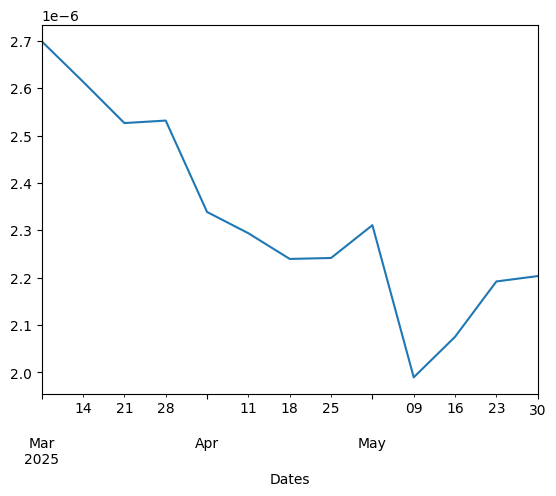

In [98]:
raw_prob.sum(1).plot()

<Axes: xlabel='Dates'>

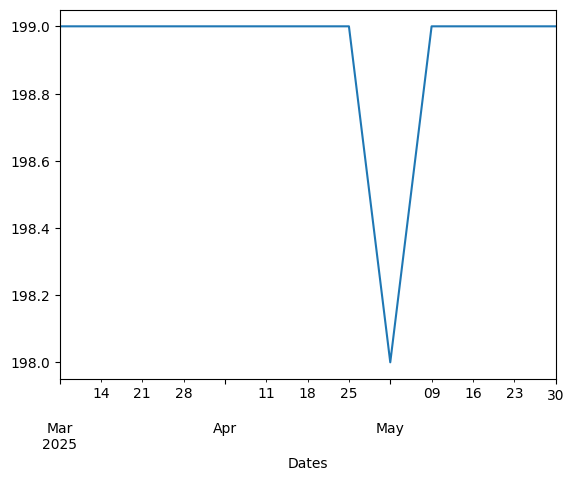

In [99]:
raw_prob.count(1).plot()

<Axes: xlabel='Dates'>

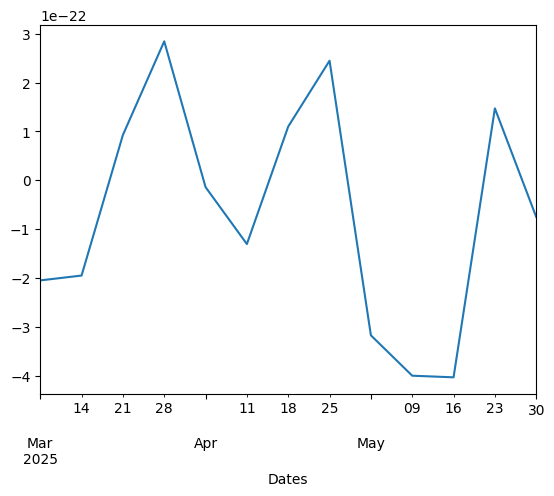

In [100]:
raw_prob.subtract(raw_prob.mean(1), axis=0).sum(1).plot()

In [101]:
# use existing weight with shift1

In [102]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [103]:
scaler = StandardScaler()
tempw = scaler.fit_transform(raw_prob.iloc[0].dropna().values.reshape(-1, 1))
temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[0].dropna().index)

In [104]:
temp_w=temp_w/abs(temp_w).sum()

In [105]:
temp_w

,0
A000080,0.000542
A000100,-0.008515
A000120,0.004116
A000150,-0.012247
A000210,0.003446
...,...
A402340,-0.001882
A450080,-0.020513
A454910,-0.002271
A456040,0.004909


In [106]:
raw_prob.iloc[-1].sort_values().dropna()

A000660    2.719475e-11
A042660    5.463795e-10
A005930    2.232766e-09
A064350    3.455630e-09
A034020    4.156947e-09
               ...     
A073240    1.723572e-08
A402340    1.809250e-08
A036460    1.903836e-08
A015760    1.939025e-08
A078930    1.952084e-08
Name: 2025-05-30 00:00:00, Length: 199, dtype: float64

In [107]:
ls_weight_ls = []
len_ls = []
for i in range(len(raw_prob.index)):
    scaler = StandardScaler()
    tempw = scaler.fit_transform(raw_prob.iloc[i].dropna().values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[i].dropna().index)
    
    # remove top bottom +/- 2stdev
    temp_w[temp_w>(temp_w.mean()+2*temp_w.std())]=2
    temp_w[temp_w<(temp_w.mean()-2*temp_w.std())]=-2

    # remove in the middle
    # temp_w[(temp_w<temp_w.mean()+temp_w.std()) & (temp_w>temp_w.mean()-temp_w.std())]=0
    
    temp_w=temp_w/abs(temp_w).sum()
    len_ls.append(len(temp_w[temp_w>0].dropna()))
    ls_weight_ls.append(temp_w)
    

<Axes: >

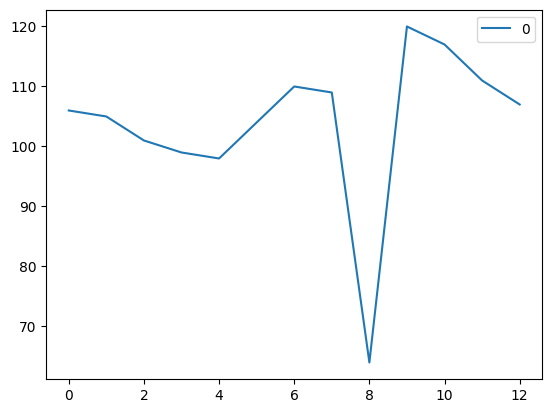

In [108]:
pd.DataFrame(len_ls).plot()

In [109]:
ls_w=pd.concat(ls_weight_ls, axis=1).T
ls_w.index=raw_prob.index

<Axes: >

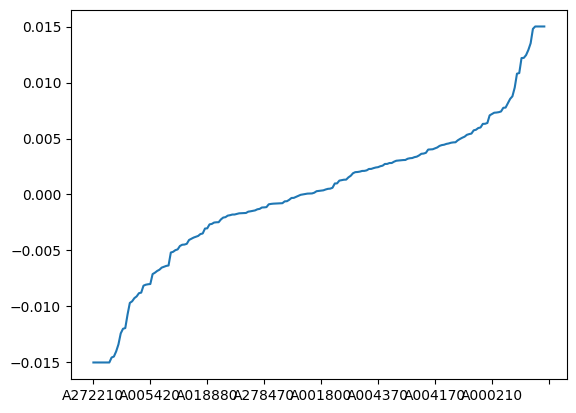

In [110]:
ls_w.iloc[-1].sort_values().dropna().plot()

In [111]:
temp_ls_w=ls_w.copy()
temp_ls_w.loc[:, 'A001570']=0

In [112]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

In [113]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

In [114]:
long_w=ls_w[temp_ls_w>0]
short_w=ls_w[temp_ls_w<0]

In [115]:
ew_long=long_w.copy()
ew_short=short_w.copy()

In [116]:
ew_long[ew_long>0]=1
ew_short[ew_short<0]=-1

In [117]:
ew_long=ew_long.div(ew_long.count(1), axis=0)
ew_short=ew_short.div(ew_short.count(1), axis=0)

<Axes: xlabel='Dates'>

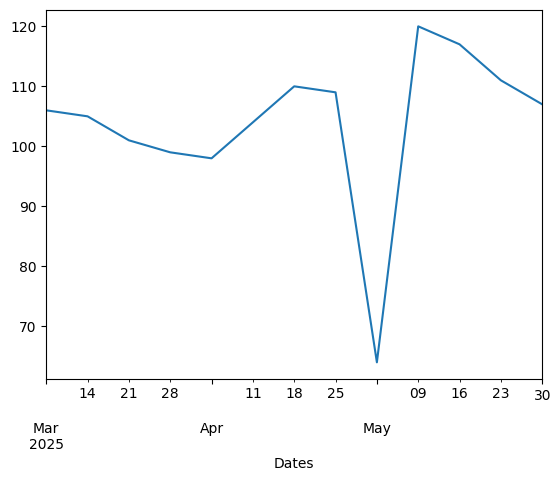

In [118]:
ew_long.count(1).plot()

In [119]:
long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*long_w.shift(1)*2
short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*short_w.shift(1)*2

In [120]:
ew_long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_long.shift(1)
ew_short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_short.shift(1)

# LS results

In [121]:
long_w.loc['2023-06-01': '2023-12-01', 'A001570'].fillna(0)

Series([], Name: A001570, dtype: float64)

/tmp/ipykernel_3735115/1600025215.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  adjprc.pct_change().loc[ls_w.index, 'A001570'].plot()


<Axes: xlabel='Dates'>

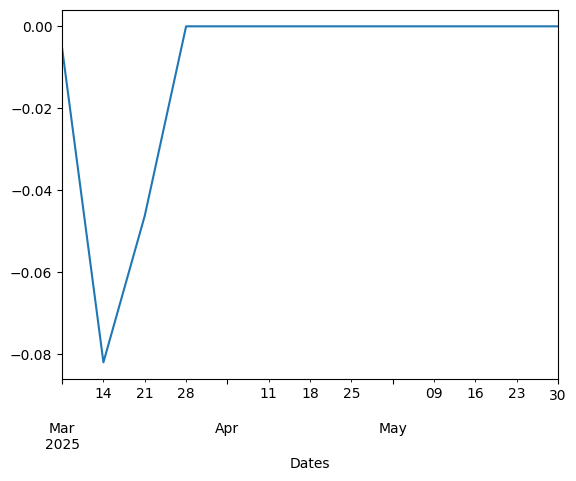

In [122]:
adjprc.pct_change().loc[ls_w.index, 'A001570'].plot()

In [123]:
ls_w.loc['2023-06-01':].index

DatetimeIndex(['2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28',
               '2025-04-04', '2025-04-11', '2025-04-18', '2025-04-25',
               '2025-05-02', '2025-05-09', '2025-05-16', '2025-05-23',
               '2025-05-30'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [124]:
adjprc.loc[ls_w.loc['2023-06-01':].index, 'A001570'].pct_change()

Dates
2025-03-07         NaN
2025-03-14    0.028331
2025-03-21   -0.262844
2025-03-28    0.000000
2025-04-04    0.000000
2025-04-11    0.000000
2025-04-18    0.000000
2025-04-25    0.000000
2025-05-02    0.000000
2025-05-09    0.000000
2025-05-16    0.000000
2025-05-23    0.000000
2025-05-30    0.000000
Name: A001570, dtype: float64

In [125]:
idx_ret['A001570'].dropna()

Dates
2025-03-14    0.0
2025-03-21   -0.0
2025-03-28    0.0
2025-04-04    0.0
2025-04-11    0.0
2025-04-18    0.0
2025-04-25    0.0
2025-05-02    0.0
2025-05-09    0.0
2025-05-16    0.0
2025-05-23    0.0
2025-05-30    0.0
Name: A001570, dtype: float64

<Axes: xlabel='Dates'>

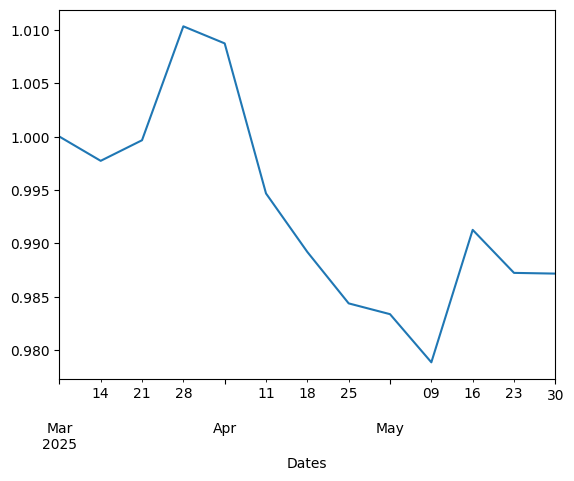

In [126]:
# raw long short 
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

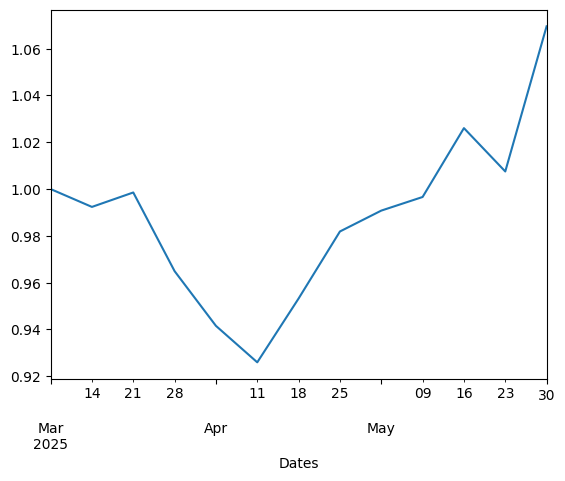

In [127]:
# raw long
(1+long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

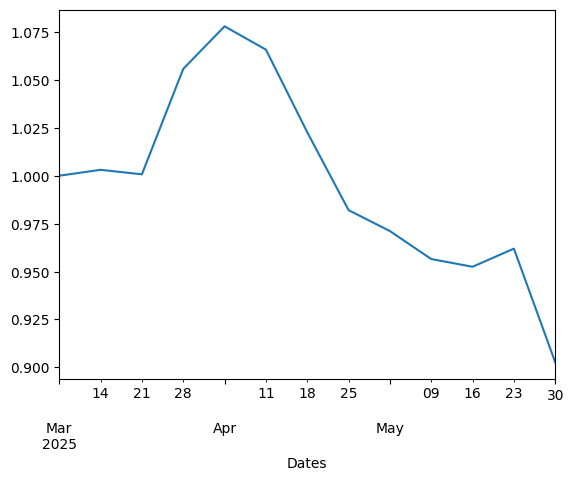

In [128]:
# raw short
(1+short_idx_ret.sum(1)).cumprod().plot()

In [129]:
# equal weight long short

<Axes: xlabel='Dates'>

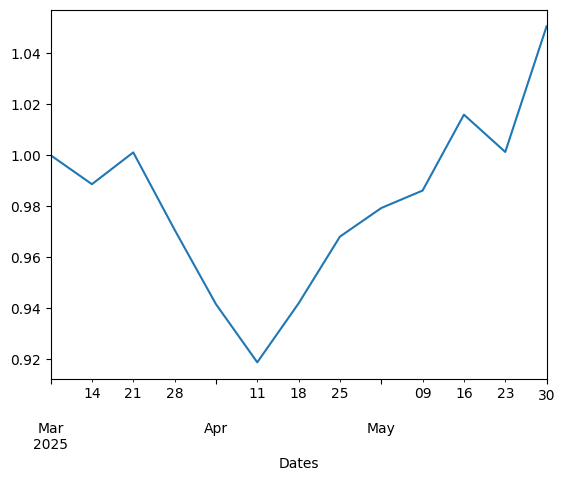

In [130]:
(1+ew_long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

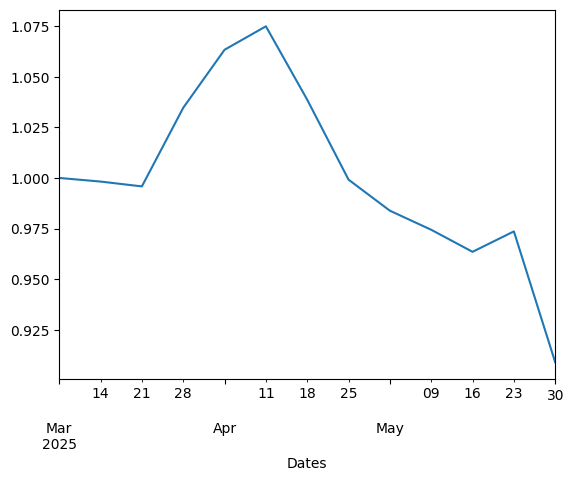

In [131]:
(1+ew_short_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

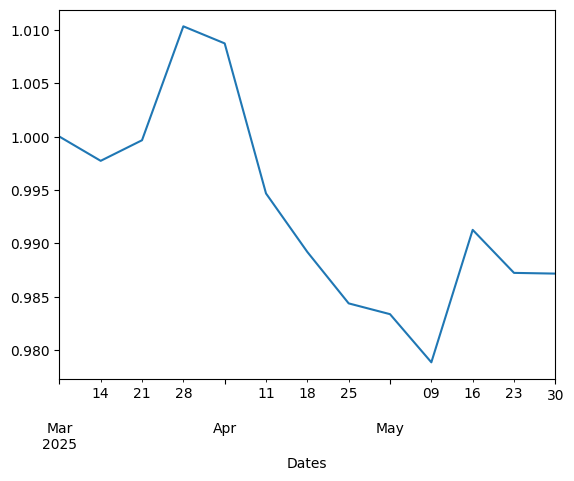

In [132]:
# remove top and bottom
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

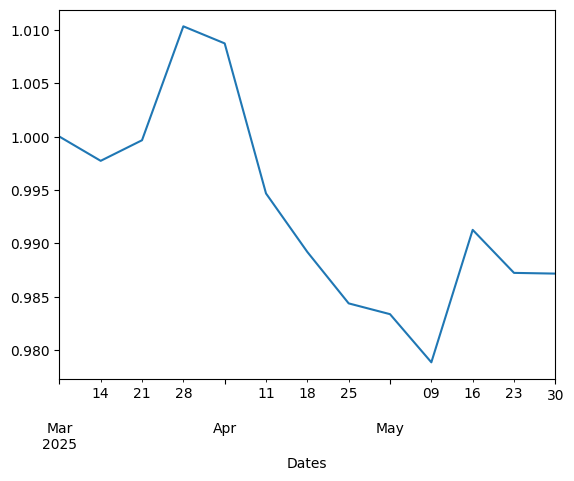

In [133]:
# remove in the middle
(1+idx_ret.sum(1)).cumprod().plot()

# optimize port

### how to optimize 
#### compare with market weight 
#### input: k200 weight, score, vol(return)


In [134]:
from scipy.optimize import minimize
import numpy as np

In [135]:
bmw=k200_df['idx_weight'].unstack()

In [136]:
bmw

Symbol,A000030,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,A000210,...,A377300,A381970,A383220,A383800,A402340,A450080,A454910,A456040,A457190,A489790
Dates,,,,,,,,,,,,,,,,,,,,,
2016-06-02,0.46,0.03,NaN,0.1,0.12,0.39,0.28,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-03,0.45,0.03,NaN,0.1,0.11,0.40,0.29,0.01,0.11,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-07,0.45,0.03,NaN,0.1,0.11,0.39,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-08,0.45,0.03,NaN,0.1,0.11,0.40,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-09,0.44,0.03,NaN,0.1,0.11,0.39,0.29,0.02,0.11,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,NaN,NaN,NaN,NaN,0.05,0.55,0.08,NaN,0.29,0.04,...,0.09,NaN,0.09,NaN,0.79,0.07,0.08,0.02,0.07,0.16
2025-05-28,NaN,NaN,NaN,NaN,0.05,0.54,0.08,NaN,0.28,0.04,...,0.09,NaN,0.09,NaN,0.84,0.08,0.08,0.02,0.07,0.16
2025-05-29,NaN,NaN,NaN,NaN,0.05,0.53,0.07,NaN,0.30,0.04,...,0.09,NaN,0.09,NaN,0.87,0.08,0.08,0.02,0.07,0.15


In [137]:
adjprc.pct_change(60)

/tmp/ipykernel_3735115/4222830641.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  adjprc.pct_change(60)


Symbol,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A460860,A462520,A465770,A900030,A900050,A900140,A950010,A950070,A950100,A950210
Dates,,,,,,,,,,,,,,,,,,,,,
2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,NaN,0.028939,0.0,-0.067130,0.129187,0.0,0.008000,-0.006186,NaN,-0.147300,...,-0.019759,-0.134757,-0.068478,NaN,0.0,0.013809,0.0,NaN,0.0,0.033122
2025-05-27,NaN,0.001562,0.0,-0.069767,0.111111,0.0,0.019169,-0.001554,NaN,-0.161085,...,-0.103226,-0.134409,-0.059933,NaN,0.0,0.002862,0.0,NaN,0.0,0.002113
2025-05-28,NaN,0.017405,0.0,0.030879,0.139241,0.0,0.107717,0.015073,NaN,-0.181676,...,-0.054083,-0.129966,-0.025143,NaN,0.0,0.061414,0.0,NaN,0.0,-0.064493


In [138]:
k200_df.index.get_level_values(0).unique()[k200_df.index.get_level_values(0).unique()>'2021-12-22']

DatetimeIndex(['2021-12-23', '2021-12-24', '2021-12-27', '2021-12-28',
               '2021-12-29', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07',
               ...
               '2025-05-20', '2025-05-21', '2025-05-22', '2025-05-23',
               '2025-05-26', '2025-05-27', '2025-05-28', '2025-05-29',
               '2025-05-30', '2025-06-02'],
              dtype='datetime64[ns]', name='Dates', length=840, freq=None)

In [139]:
ls_w.index

DatetimeIndex(['2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28',
               '2025-04-04', '2025-04-11', '2025-04-18', '2025-04-25',
               '2025-05-02', '2025-05-09', '2025-05-16', '2025-05-23',
               '2025-05-30'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [140]:
comm_dates=ls_w.index.intersection(k200_df.index.get_level_values(0).unique())
rebal_dates = proc.find_entire_rebalancing_dates(comm_dates)

lack of the beginning part of data  2025-02-28 00:00:00 2025-03-07 00:00:00
expected date is not in inner dates 2025-03-31 00:00:00
2025-03-31 00:00:00 2025-03-28 00:00:00
expected date is not in inner dates 2025-04-30 00:00:00
2025-04-30 00:00:00 2025-04-25 00:00:00


In [141]:
rebal_dates

DatetimeIndex(['2025-03-28', '2025-04-25', '2025-05-30'], dtype='datetime64[ns]', freq=None)

In [142]:
bmw

Symbol,A000030,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,A000210,...,A377300,A381970,A383220,A383800,A402340,A450080,A454910,A456040,A457190,A489790
Dates,,,,,,,,,,,,,,,,,,,,,
2016-06-02,0.46,0.03,NaN,0.1,0.12,0.39,0.28,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-03,0.45,0.03,NaN,0.1,0.11,0.40,0.29,0.01,0.11,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-07,0.45,0.03,NaN,0.1,0.11,0.39,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-08,0.45,0.03,NaN,0.1,0.11,0.40,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-09,0.44,0.03,NaN,0.1,0.11,0.39,0.29,0.02,0.11,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,NaN,NaN,NaN,NaN,0.05,0.55,0.08,NaN,0.29,0.04,...,0.09,NaN,0.09,NaN,0.79,0.07,0.08,0.02,0.07,0.16
2025-05-28,NaN,NaN,NaN,NaN,0.05,0.54,0.08,NaN,0.28,0.04,...,0.09,NaN,0.09,NaN,0.84,0.08,0.08,0.02,0.07,0.16
2025-05-29,NaN,NaN,NaN,NaN,0.05,0.53,0.07,NaN,0.30,0.04,...,0.09,NaN,0.09,NaN,0.87,0.08,0.08,0.02,0.07,0.15


In [143]:
ls_w.iloc[-1].describe()

count    199.000000
mean       0.000098
std        0.006656
min       -0.015010
25%       -0.003035
50%        0.000321
75%        0.004031
max        0.015010
Name: 2025-05-30 00:00:00, dtype: float64

In [144]:
import optuna

In [145]:
# study=optuna.create_study(direction='maximize')
# study.optimize(port_objective, n_trials=30)

In [146]:
# study.best_trials

In [147]:
data_COM_nodup.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [148]:
bmw.loc[rebal_dates[-1]]

Symbol
A000030     NaN
A000050     NaN
A000060     NaN
A000070     NaN
A000080    0.05
           ... 
A450080    0.08
A454910    0.08
A456040    0.02
A457190    0.07
A489790    0.15
Name: 2025-05-30 00:00:00, Length: 307, dtype: float64

In [149]:
pd.concat([data_COM_nodup.loc[rebal_dates[-1], 'FG_IndustryGroup_Idx'], bmw.loc[rebal_dates[-1]]], axis=1).groupby('FG_IndustryGroup_Idx').sum()

,2025-05-30 00:00:00
FG_IndustryGroup_Idx,
기타금융,0.19
내구 소비재 및 의류,1.52
디스플레이,0.21
미디어,0.58
반도체,32.14
보험,2.31
부동산,0.00
상업서비스,3.76
생활용품,1.17


In [150]:
import warnings
warnings.simplefilter('error', RuntimeWarning)

In [151]:
rebal_dates

DatetimeIndex(['2025-03-28', '2025-04-25', '2025-05-30'], dtype='datetime64[ns]', freq=None)

In [152]:
size_label=data_COM_nodup.loc[rebal_dates, 'KSECapSize']
size_label=size_label.unstack().ffill().stack()

In [153]:
sector_label=data_COM_nodup.loc[rebal_dates, 'FG_IndustryGroup_Idx']
sector_label=sector_label.unstack().ffill().stack()

In [154]:
sector_label

Dates       Symbol 
2025-03-28  A000020       제약 및 바이오
            A000040       자동차 및 부품
            A000050    내구 소비재 및 의류
            A000070             소재
            A000080       음식료 및 담배
                          ...     
2025-05-30  A457190             소재
            A460850             소재
            A460860             소재
            A462520             소재
            A465770             운송
Length: 2358, dtype: object

In [155]:
bmw['A005930']

Dates
2016-06-02    21.89
2016-06-03    22.07
2016-06-07    22.09
2016-06-08    22.02
2016-06-09    22.05
              ...  
2025-05-27    21.78
2025-05-28    22.26
2025-05-29    21.93
2025-05-30    22.18
2025-06-02    22.41
Name: A005930, Length: 2206, dtype: float64

In [157]:
ls_w.iloc[-1]

A000080    0.003075
A000100   -0.011936
A000120    0.008160
A000150   -0.008820
A000210    0.007185
             ...   
A450080   -0.003781
A454910   -0.000843
A456040    0.008772
A457190   -0.004492
A003240   -0.006462
Name: 2025-05-30 00:00:00, Length: 200, dtype: float64

In [158]:
from scipy import stats

In [159]:
import logging
logging.basicConfig(level=logging.INFO)

In [160]:
# def score_objective(weight, score, cov):
#     weight_adj=np.where(weight<10**-3, 0, np.maximum(weight, 10**-3))

#     try:
#         # Check for specific error message before sqrt
#         if np.any(np.isnan(np.dot(weight_adj.T, np.dot(cov, weight_adj)))):
#             raise ValueError("Encountered NaN values during portfolio volatility calculation.")
#         port_vol = np.sqrt(np.dot(weight_adj.T, np.dot(cov, weight_adj)))
    
#     except (ValueError, RuntimeWarning) as e:
#         print(w_diff.isin([np.inf, -np.inf]).any().any())
#         print(cov.isin([np.inf, -np.inf]).any().any())
#         print(np.dot(cov, weight_adj))
#         print(np.dot(weight_adj.T, np.dot(cov, weight_adj)))
#         print("Warning: Encountered errors during portfolio volatility calculation.")
#         print(e)
    
#     adj_sharpe= score.sum() / port_vol
#     return -adj_sharpe

def score_objective2(weight, bm_weight, score, cov):
    # weight_adj=np.where(weight<10**-3, 0, np.maximum(weight, 10**-3))
    scores_series = pd.Series(score)
    
    lower_bound = scores_series.quantile(0.25)
    upper_bound = scores_series.quantile(0.5)
    
    # use top and bottom scores & drop low weights 
    score_adj = np.where((score <= upper_bound)&(score >=lower_bound), 0, score)
    weight_adj=np.where(weight<10**-3, 0, np.maximum(weight, 10**-3))
    
    w_diff=abs(weight_adj-bm_weight)
    
    if w_diff.sum()==0:
        return 0
    try:
        # Check for specific error message before sqrt
        if np.any(np.isnan(np.dot(w_diff.T, np.dot(cov, w_diff)))):
            raise ValueError("Encountered NaN values during portfolio volatility calculation.")
        port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
    
    except (ValueError, RuntimeWarning) as e:
        print(w_diff.isin([np.inf, -np.inf]).any().any())
        print(cov.isin([np.inf, -np.inf]).any().any())
        print(np.dot(cov, w_diff))
        print(np.dot(w_diff.T, np.dot(cov, w_diff)))
        print("Warning: Encountered errors during portfolio volatility calculation.")
        print(e)
    
    adj_sharpe=(w_diff*score_adj).sum() / port_vol
    # penalty = np.sum((score)**1)
    return -adj_sharpe


def selective_sign_constraint(weights, scores, top_n=10, bottom_n=10):
    # Get the indices of the top N positive scores and bottom N negative scores
    top_indices = np.argsort(scores)[-top_n:]
    bottom_indices = np.argsort(scores)[:bottom_n]
    
    # Create a boolean array indicating whether to apply the constraint (True for top/bottom scores)
    constraint_applied = np.zeros_like(scores, dtype=bool)
    constraint_applied[top_indices] = True
    constraint_applied[bottom_indices] = True
    
    # Apply sign constraint only for top/bottom scores (return 0 for others)
    return weights * scores * constraint_applied 
    
    
def create_excludingMatrix(temp_port_score):
    # B = np.eye(len(temp_port_score))
    # B[temp_port_score.isnull()] = 0
    B = np.zeros(len(temp_port_score))
    
    # Set entries corresponding to non-selected stocks (e.g., those with NaN scores) to 0
    B[temp_port_score.isnull()] = 1
        
    return B

def create_sectorMatrix(temp_bm_sectorw, temp_bm_stockw):
    # sector constraints variables       
    sector_mapping = {sector: idx for idx, sector in enumerate(temp_bm_sectorw.index)}

    A = np.zeros((len(temp_bm_sectorw), len(temp_bm_stockw)), dtype=int)
    for i, stock in enumerate(temp_bm_stockw.index):
        sector_idx = sector_mapping[temp_bm_stockw.loc[temp_bm_stockw.index == stock, 'sector'].iloc[0]]
        A[sector_idx, i] = 1
    
    return A


def create_sizeMatrix(temp_bm_sizew, temp_bm_stockw):
    # sector constraints variables       
    size_mapping = {size: idx for idx, size in enumerate(temp_bm_sizew.index)}

    C = np.zeros((len(temp_bm_sizew), len(temp_bm_stockw)), dtype=int)
    for i, stock in enumerate(temp_bm_stockw.index):
        size_idx = size_mapping[temp_bm_stockw.loc[temp_bm_stockw.index == stock, 'size'].iloc[0]]
        C[size_idx, i] = 1
    
    return C


def convert_lsScore(port_score, short_num, long_num):
    """
        when score is all positive, it convert to the mean of score is 0 so that it can be used in Long/Short       
    """
    # convert into L/S scores
    sort_score=port_score.sort_values().dropna().copy()
    port_score[:]=np.nan # port_score.mean()
    if short_num>0:
        port_score[sort_score.iloc[:short_num].index]=sort_score.iloc[:short_num]

    port_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]       
    # port_score=port_score.fillna(0)
    
    return port_score


def handle_missingCol(port_df, bm_df):
    """
        compare given port column and BM column
    """
    missing_cols = set(bm_df.index) - set(port_df.index)

    if len(missing_cols)>0:
    # if method=='fill':
        
        # Add the missing columns to df1 with NaN values
        for col in missing_cols:
            print('missing col: ', col)
            # df1.loc[col] = pd.Series([None] * len(df1), index=df1.index)
            port_df.loc[col]=None
        # port_df=port_df.loc[bm_df.index]
        
    # elif len(bm_df.index) < len(port_df.index):
        # elif method=='drop':
        # comm_col=port_df.index.intersection(bm_df.index)
        # port_df=port_df.loc[comm_col]
    
    port_df=port_df.loc[bm_df.index]
        
    print(f"port shape: {port_df.shape}, bm shape: {bm_df.shape}, compare : {(port_df.index==bm_df.index).sum()}")
    return port_df


def optimize_portfolio3_(port_weight, bm_weight, adj_prc, 
                         sector_info, size_info, 
                         excess_stockw, excess_sectorw, excess_sizew):    
    # slice BM weight   
    temp_bm_weight=bm_weight/bm_weight.sum()
    print('bmw: ', temp_bm_weight.loc['A005930'])
    
    temp_raw_port=port_weight.dropna()
    print('rawscore: ', temp_raw_port.loc['A005930'])
    
    # slice port weight
    temp_port=handle_missingCol(temp_raw_port, temp_bm_weight)
    print('bm adj score: ', temp_port.shape, temp_port.dropna().shape)
    temp_port=temp_port.fillna(0)
    print('l/s num: ', temp_port.dropna().shape)

    # temp_score=convert_lsScore(temp_port, short_num, long_num)
    # convert score into long/short score
    # B=create_excludingMatrix(temp_port)
    # print(B.shape, B.sum())        

    # compute covariance
    temp_cov=adjprc[temp_port.index].pct_change(20).dropna(how='all', axis=0).cov()
    temp_cov=temp_cov.fillna(0)

    """
     concat with bm stock weights include all stocks in BM 
     to compute sector weights, all BM stocks required
     excluding matrix so that it does not include not picked up stocks
    """
    
    temp_bm_stockw=pd.concat([sector_info.dropna(), size_info.dropna(), temp_bm_weight], axis=1)
    temp_bm_stockw.columns=['sector', 'size', 'bm_weight']
    temp_bm_stockw=temp_bm_stockw.loc[temp_port.index]
    print(temp_bm_stockw['sector'])
    print(temp_bm_stockw['size'])
    
    temp_bm_sectorw=temp_bm_stockw[['sector', 'bm_weight']].groupby('sector').sum()
    temp_bm_sizew=temp_bm_stockw[['size', 'bm_weight']].groupby('size').sum()
    
    print('bm sectorw: ', temp_bm_sectorw)
    print('bm size: ', temp_bm_sizew)

    A=create_sectorMatrix(temp_bm_sectorw, temp_bm_stockw)
    C=create_sizeMatrix(temp_bm_sizew, temp_bm_stockw)
    
    # Define the constraints (weights sum to 1)
    const1 = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    stock_cons = {'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight) + excess_stockw}
    # sign_cons = {'type': 'ineq', 'fun': lambda x: selective_sign_constraint((x-temp_bm_weight), port_weight)}
    sector_cons = {'type': 'ineq', 'fun': lambda x: -np.abs(np.dot(A, x) - temp_bm_sectorw.values.flatten()) + excess_sectorw}
    size_cons = {'type': 'ineq', 'fun': lambda x: -np.abs(np.dot(C, x) - temp_bm_sizew.values.flatten()) + excess_sizew}
    
    # Define the bounds (each weight is between 0 and 1)
    bounds = tuple((0, 1) for asset in range(len(temp_port.index)))
    
    constraints=[const1, stock_cons, sector_cons, size_cons] #
    
    # Initial guess (equal weights)
    initial_guess = [1 / len(temp_port.index) for asset in range(len(temp_port.index))]
    # initial_guess=np.dot(B, initial_guess)
    # initial_guess = temp_bm_weight.values
    
    # Perform the optimization
    print(temp_bm_weight.shape, temp_port.shape, temp_cov.shape)
    options = {'maxiter': 1000, 'ftol': 1e-8, 'gtol': 1e-8}
    result = minimize(score_objective2, initial_guess, args=(temp_bm_weight, temp_port, temp_cov), method='SLSQP', bounds=bounds, constraints=constraints, options=options)
        
    # Extract the optimized weights
    optimal_weights = result.x
    optw_df=pd.DataFrame(optimal_weights, index=temp_port.index)
    
    return optw_df


In [161]:
stockw=.003
sectorw=.04
sizew=.06
# long_num=75
# short_num=30
bmw['A489790']=None
final_port_opt=optimize_portfolio3_(ls_w.iloc[-1], 
                                    bmw.loc[period2].dropna(), 
                                    adjprc.loc[period1:period2],
                                    sector_label.loc[period2],
                                    size_label.loc[period2],
                                    stockw, 
                                    sectorw,
                                    sizew)

bmw:  0.22211095533747252
rawscore:  -0.015010388304197597
port shape: (199,), bm shape: (199,), compare : 199
bm adj score:  (199,) (199,)
l/s num:  (199,)


/tmp/ipykernel_3735115/2076694445.py:168: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  temp_cov=adjprc[temp_port.index].pct_change(20).dropna(how='all', axis=0).cov()


Symbol
A000080    음식료 및 담배
A000100    제약 및 바이오
A000120          운송
A000150         자본재
A000210          소재
             ...   
A402340         자본재
A450080        하드웨어
A454910         자본재
A456040          소재
A457190          소재
Name: sector, Length: 199, dtype: object
Symbol
A000080    코스피 중형주
A000100    코스피 대형주
A000120    코스피 중형주
A000150    코스피 대형주
A000210    코스피 중형주
            ...   
A402340    코스피 대형주
A450080    코스피 대형주
A454910    코스피 대형주
A456040    코스피 중형주
A457190    코스피 중형주
Name: size, Length: 199, dtype: object
bm sectorw:              bm_weight
sector               
기타금융         0.001903
내구 소비재 및 의류  0.015221
디스플레이        0.002103
미디어          0.005808
반도체          0.321851
보험           0.023132
상업서비스        0.037653
생활용품         0.011716
소비자 서비스      0.002704
소재           0.044462
소프트웨어         0.05007
에너지          0.022331
운송           0.030443
유통           0.006409
유틸리티         0.010014
은행           0.093932
음식료 및 담배     0.020529
의료장비 및 서비스   0.000601
자동차 및 부품     0.059884
자본

/tmp/ipykernel_3735115/2076694445.py:212: OptimizeWarning: Unknown solver options: gtol
  result = minimize(score_objective2, initial_guess, args=(temp_bm_weight, temp_port, temp_cov), method='SLSQP', bounds=bounds, constraints=constraints, options=options)


In [162]:
bmw.loc['2024-11-29', "A005930"]

23.73

In [163]:
final_port_opt.sort_values(0, ascending=False)

,0
Symbol,
A005930,0.222111
A000660,0.096839
A105560,0.029036
A012450,0.024033
A005380,0.021058
...,...
A005250,0.000047
A006360,0.000045
A111770,0.000042


In [164]:
len(final_port_opt[final_port_opt>0].dropna())

199

In [165]:
final_port=final_port_opt.copy()[0]
final_port=final_port[final_port>10**-3].dropna()


In [166]:
final_port.sort_values(ascending=False)

Symbol
A005930    0.222111
A000660    0.096839
A105560    0.029036
A012450    0.024033
A005380    0.021058
             ...   
A139130    0.001303
A090430    0.001248
A001440    0.001187
A047040    0.001147
A011170    0.001000
Name: 0, Length: 109, dtype: float64

In [167]:
final_port[final_port>0].to_csv(f"../data/output/weight/{period2}_{stockw}_{sectorw}_{sizew}_port2.csv")

In [ ]:
compare_bmw=bmw.loc[period2, final_port_opt.index].sort_values(ascending=False)
compare_bmw=compare_bmw/100
weight_diff=final_port_opt[0].dropna() - compare_bmw
weight_diff.sort_values(ascending=False).dropna()

In [ ]:
pd.concat([weight_diff, size_label.loc[period2]], axis=1).groupby(1).sum(0)

In [ ]:
pd.concat([weight_diff, sector_label.loc[period2]], axis=1).groupby(1).sum(0).sort_values(0)

In [ ]:
sector_label.loc[(period2, ['A373220', 'A005930'])]

### check top and bottom scores 

In [ ]:
init_scores=pd.concat([ls_w.iloc[-1], raw_prob.iloc[-1], weight_diff.loc[ls_w.iloc[-1].dropna().index]], axis=1)
init_scores.columns=['normalize', 'raw', 'wdiff']
init_scores=init_scores.sort_values('raw', ascending=False).dropna()

In [ ]:
init_scores.head(20)

In [ ]:
init_scores.tail(20)

In [ ]:
ow_port0=init_scores.head(20)
uw_port0=init_scores.tail(20)

In [ ]:
adj_ow=ow_port0['wdiff'][ow_port0['wdiff']>0].mean()
adj_uw=uw_port0['wdiff'][uw_port0['wdiff']<0].mean()
adj_uw, adj_ow

### find weights ow but less than mean and uw that is over the mean
### they will be filled and unfilled in the below

In [ ]:
ow_fix=ow_port0[ow_port0['wdiff']<0]
uw_fix=uw_port0[uw_port0['wdiff']>0]
ow_fix, uw_fix

In [ ]:
1-final_port_opt[final_port_opt>10**-3].dropna().sum()

In [ ]:
final_port_opt.sort_values(0)

# first fill weight
### remove weights under 10***-3 and then add those to existing weights

In [ ]:
final_port=final_port_opt.copy()[0]
final_port=final_port[final_port>10**-3].dropna()

for i in range(len(uw_fix)):
    unfill_w=uw_fix.index[i]
    print(unfill_w)
    final_port.loc[unfill_w]=compare_bmw.loc[unfill_w]+adj_uw

In [ ]:
final_port.sort_values()

In [ ]:
final_port.sum()

In [ ]:
additional_weight=1-final_port.sum() # is it possible (addtional weight > max ow) ?
additional_weight

In [ ]:
np.ceil(additional_weight/adj_ow), adj_ow

In [ ]:
additional_weight, adj_ow

In [ ]:
np.ceil(additional_weight/adj_ow)

In [ ]:
fill_num=int(np.ceil(additional_weight/adj_ow)) # it checks whether addtional weights over mean ow
if fill_num==0:
    final_port.loc[ow_fix.index[0]]=additional_weight
    print(ow_fix.index[0])
else:
    for i in range(min(fill_num, len(ow_fix))):
        fill_w=ow_fix.index[i]
        if (1-final_port.sum())>adj_ow:
            final_port.loc[fill_w]=compare_bmw.loc[fill_w]+(additional_weight/fill_num)
        else:
            final_port.loc[fill_w]=compare_bmw.loc[fill_w]+(1-final_port.sum())
        print(fill_w)

In [ ]:
1-final_port.sum(), len(final_port), final_port.sum()

In [ ]:
final_port.sort_values()

# second fill weight
### find remaining weight 
### check the weight difference and add weights to stocks whose weights are under max weight

In [ ]:
rem_w=1-final_port.sum()
rem_w

In [ ]:
(final_port-compare_bmw).dropna().sort_values(ascending=False), stockw

In [ ]:
final_wdiff=(final_port-compare_bmw).dropna().sort_values(ascending=False)

In [ ]:
final_wdiff

In [ ]:
i=0
while rem_w>0:
    if (final_wdiff.iloc[i] < stockw) & (final_wdiff.iloc[i]>0):
        add_w=stockw-final_wdiff.iloc[i]
        if rem_w<add_w:
            final_port.loc[final_wdiff.index[i]]+=rem_w
        else:
            final_port.loc[final_wdiff.index[i]]+=add_w
        rem_w-=add_w
        print(final_wdiff.index[i], add_w)
        i+=1
    else:
        i+=1
        
        continue

In [ ]:
final_port.shape, final_port.sum()

In [ ]:
final_port

In [ ]:
# 복제율
1- abs((final_port - compare_bmw).dropna()).sum()/2

In [ ]:
final_port[final_port>0].sort_values()

In [ ]:
final_port[final_port>0].sum()

In [ ]:
final_port[final_port>0].to_csv(f"../data/output/weight/{period2}_{stockw}_{sectorw}_{sizew}_port2.csv")

In [ ]:
check_stockw=[]
for rd in rebal_dates:
    check_stockw.append(daily_optw.loc[rd, 'A005930']*100-bmw.loc[rd, 'A005930'])

In [ ]:
# """
#     exclude:
#     long_term: neg & mid_term: neg & short_term: neg
#     long_term: pos & short_term: neg
    
    
# """

# long_term=252
# mid_term=60
# short_term=20
# filtered_stocks=[]

# for symbol in weight_diff.index:
#     long_x=np.arange(long_term)
#     long_y=adjprc.iloc[-long_term:][symbol]
#     long_slope, _, long_rvalue, long_pvalue, long_std_err=stats.linregress(long_x, long_y)
    
#     mid_x=np.arange(mid_term)
#     mid_y=adjprc.iloc[-mid_term:][symbol]
#     mid_slope, _, mid_rvalue, mid_pvalue, mid_std_err=stats.linregress(mid_x, mid_y)

#     short_x=np.arange(short_term)
#     short_y=adjprc.iloc[-short_term:][symbol]
#     short_slope, _, short_rvalue, short_pvalue, short_std_err=stats.linregress(short_x, short_y)

    
#     if long_slope <0 and mid_slope <0:
#         filtered_stocks.append({
#                                 'symbol': symbol,
#                                 'long_slope': np.round(long_slope, 3),
#                                 'long_rvalue': np.round(long_rvalue, 3),
#                                 'long_pvalue': np.round(long_pvalue, 3),
#                                 'mid_slope': np.round(mid_slope, 3),
#                                 'mid_rvalue': np.round(mid_rvalue, 3),
#                                 'mid_pvalue': np.round(mid_pvalue, 3),
#                                 'short_slope': np.round(short_slope, 3),
#                                 'short_rvalue': np.round(short_rvalue, 3),
#                                 'short_pvalue': np.round(short_pvalue, 3)
#                                 })
        
#     elif long_slope >0 and short_slope <0:
#         filtered_stocks.append({
#                                 'symbol': symbol,
#                                 'long_slope': np.round(long_slope, 3),
#                                 'long_rvalue': np.round(long_rvalue, 3),
#                                 'long_pvalue': np.round(long_pvalue, 3),
#                                 'mid_slope': np.round(mid_slope, 3),
#                                 'mid_rvalue': np.round(mid_rvalue, 3),
#                                 'mid_pvalue': np.round(mid_pvalue, 3),
#                                 'short_slope': np.round(short_slope, 3),
#                                 'short_rvalue': np.round(short_rvalue, 3),
#                                 'short_pvalue': np.round(short_pvalue, 3)
#                                 })
                               

In [ ]:
filered_df=pd.DataFrame(filtered_stocks).sort_values(by='long_slope')

In [ ]:
filtered_stocks=list(set(weight_diff[weight_diff>.001].index).intersection(set(filered_df['symbol'])))
len(filtered_stocks)

In [ ]:
eqw=bmw.loc['2024-08-30', filered_df['symbol'].values]
final_port=final_port_opt.copy()[0]

In [ ]:
final_port.loc[filtered_stocks]=eqw/100


In [ ]:
final_port.loc[filtered_stocks]=eqw/100

weight_diff2=final_port.dropna()-compare_bmw
weight_diff2=weight_diff2+abs(weight_diff2.min())

additional_weights=weight_diff2/weight_diff2.sum() * (1-final_port.sum())
final_port_adj=final_port+additional_weights

In [ ]:
final_port_adj.sort_values()

In [ ]:
# final_port_adj.to_csv(f"../data/output/weight/{period2}_screened_weight_stock{stockw}_port2.csv")
# (final_port_adj-compare_bmw).dropna().sort_values().to_csv(f"../data/output/weight/{period2}_screened_weightdiff_stock{stockw}_port.csv")